# XGBoost 3-Class - SMOTE & Recall Optimized

**Goal:** Maximize 'Death' class detection to match Random Forest performance.

**Key Improvements Applied:**
1. **SMOTE Oversampling**: Synthetically increasing 'Death' samples in training data.
2. **Aggressive Class Weights**: Manually setting higher penalties (3.0x) for missing fatal accidents.
3. **Threshold Tuning**: Lowering the probability bar for predicting 'Death'.

In [2]:
#pip install xgboost scikit-learn pandas numpy matplotlib seaborn imbalanced-learn

In [3]:
#pip install xgboost

In [41]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix, precision_recall_fscore_support, auc, ConfusionMatrixDisplay, make_scorer)
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

## 1. Data Prep & Encoding

In [5]:
df = pd.read_csv('combined_accidents_balanced.csv')

# Select Features
df_sel = df[['injury_severity', 'affected_party', 'primary_accident_type_code', 
             'rain_today', 'vehicle_type_score', 'age_min_encoded', 'rush_hour']].copy()

# Encoding
df_sel['injury_severity'] = df_sel['injury_severity'].map({'minor': 0, 'serious': 1, 'grievous': 1, 'death': 2})
df_sel['affected_party'] = df_sel['affected_party'].map({'pedestrian': 0, 'cyclist': 1, 'motorcyclist': 2, 'driver': 3})
df_sel['primary_accident_type_code'] = df_sel['primary_accident_type_code'].map({'FXOBJ': 0, 'PED': 1, 'COLL': 2, 'OTH': 3})
df_sel['rain_today'] = df_sel['rain_today'].astype(int)
df_sel['rush_hour'] = df_sel['rush_hour'].astype(int)

print("Class Counts (Original):")
print(df_sel['injury_severity'].value_counts().sort_index())

Class Counts (Original):
injury_severity
0     91
1    102
2     39
Name: count, dtype: int64


## 2. Split Data

In [6]:
X = df_sel.drop('injury_severity', axis=1)
y = df_sel['injury_severity']

# Stratified Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

## 3. Apply SMOTE (Synthetic Minority Over-sampling)
We artificially generate new 'Death' samples only in the training set to help the model learn the boundary.

In [7]:
# SMOTE to balance the training classes
# k_neighbors=3 because we only have ~27 death samples
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Original Train Shape: {y_train.shape}")
print(f"Resampled Train Shape: {y_train_res.shape}")
print("\nResampled Class Distribution:")
print(y_train_res.value_counts())

Original Train Shape: (162,)
Resampled Train Shape: (213,)

Resampled Class Distribution:
injury_severity
1    71
0    71
2    71
Name: count, dtype: int64


## 4. Aggressive Class Weights
Even with SMOTE, we add extra weight to the Death class to force the model to prioritize it.

In [8]:
# Define manual weights to penalize Death errors more heavily
# 0 (Minor): 1.0
# 1 (Serious): 1.5
# 2 (Death): 3.0  <-- Heavy penalty for missing deaths

# Create weights for the resampled data
sample_weights = np.ones(len(y_train_res))
for idx, val in enumerate(y_train_res):
    if val == 1: sample_weights[idx] = 1.5
    if val == 2: sample_weights[idx] = 3.0

print("Weights configured.")

Weights configured.


## 5. Hyperparameter Optimization (Random Search)
#We search for parameters that maximize **Macro F1 Score** (average F1 of Minor, Serious, Death).

In [9]:
param_dist = {
    'n_estimators': [10, 30, 50, 100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5, 1, 2],
    'reg_alpha': [0, 0.1, 1, 5],
    'reg_lambda': [0.1, 1, 5, 10]
}

xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

# Macro F1 scorer
#scorer = make_scorer(f1_score, average='macro')
score = ["f1_macro"]

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=50,
    #scoring=scorer,
    scoring=score,
    cv=StratifiedKFold(n_splits=3),
    verbose=1,
    random_state=42,
    n_jobs=-1, refit="f1_macro"
)

print("Starting Hyperparameter Search...")
random_search.fit(X_train_res, y_train_res, sample_weight=sample_weights)

best_model = random_search.best_estimator_
fit_time = random_search.cv_results_['mean_fit_time']
mean__fittime = np.mean(fit_time)

print("\nBest Parameters Found:")
print(random_search.best_params_)
print(f"Best CV Macro F1: {random_search.best_score_:.4f}")
print(f"Mean Fit Time: {mean__fittime:.4f}")



Starting Hyperparameter Search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best Parameters Found:
{'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Best CV Macro F1: 0.7161
Mean Fit Time: 0.0685


## 6. Train XGBoost with Best Hyperparameters

In [27]:
#apply the best model on the validation set
# Get the best model from GridSearchCV and make predictions using the validation set

y_pred_rs = best_model.predict(X_val)

f1_scores_val = f1_score(y_val, y_pred_rs,average='macro')
bal_accuracy_val = balanced_accuracy_score(y_val, y_pred_rs)
accuracy_val = accuracy_score(y_val, y_pred_rs)
print("✓ Model Trained")
print(f"Best Model F1 Macro Score / Validation Set: {f1_scores_val:.2f}")
print(f"Best Model Balanced Accuracy / Validation Set: {bal_accuracy_val:.2f}")
print(f"Best Model Accuracy / Validation Set: {accuracy_val:.2f}")


✓ Model Trained
Best Model F1 Macro Score / Validation Set: 0.65
Best Model Balanced Accuracy / Validation Set: 0.66
Best Model Accuracy / Validation Set: 0.69


In [29]:
#apply the best model on the test set
y_test_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)

f1_scores = f1_score(y_test, y_test_pred ,average='macro')
bal_accuracy = balanced_accuracy_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
print("✓ Model Trained")
print(f"Best Model F1 Macro Score / Test Set: {f1_scores:.2f}")
print(f"Best Model Balanced Accuracy / Test Set: {bal_accuracy:.2f}")
print(f"Best Model Accuracy / Test Set: {accuracy:.2f}")

✓ Model Trained
Best Model F1 Macro Score / Test Set: 0.60
Best Model Balanced Accuracy / Test Set: 0.64
Best Model Accuracy / Test Set: 0.63


the model performs poorer on the test set

## 7. Final Evaluation


FINAL RESULTS
              precision    recall  f1-score   support

       Minor       0.86      0.86      0.86        14
     Serious       0.67      0.40      0.50        15
       Death       0.33      0.67      0.44         6

    accuracy                           0.63        35
   macro avg       0.62      0.64      0.60        35
weighted avg       0.69      0.63      0.63        35



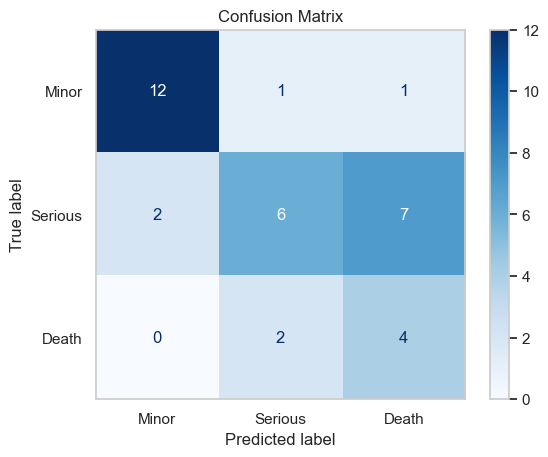

Death Cases Correctly Identified: 4/6 (66.7%)


In [31]:
# Apply optimal threshold to Test Set
print(f"\nFINAL RESULTS")
print("="*60)

print(classification_report(y_test, y_test_pred, target_names=['Minor', 'Serious', 'Death']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Minor', 'Serious', 'Death'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.title(f"Confusion Matrix")
plt.show()

death_correct = cm[2,2]
death_total = cm[2].sum()
print(f"Death Cases Correctly Identified: {death_correct}/{death_total} ({death_correct/death_total:.1%})")

## 8. Comprehensive Performance Metrics

In [38]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
f1_macro = f1_score(y_test, y_test_pred, average='macro')
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

# Calculate ROC-AUC
y_probs = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr', average='weighted')

print("=" * 70)
print("DETAILED PERFORMANCE METRICS")
print("=" * 70)
print(f"\nOverall Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Balanced Accuracy: {balanced_acc:.4f}")
print(f"  Weighted F1: {f1_weighted:.4f}")
print(f"  Macro F1: {f1_macro:.4f}")
print(f"  ROC-AUC (weighted): {roc_auc:.4f}")

print("\nPer-Class Performance:")
print("-" * 30)
class_names = ['Minor', 'Serious', 'Death']
for i, name in enumerate(class_names):
    print(f"{name:<10} | Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1: {f1[i]:.4f}")
print("-" * 30)

DETAILED PERFORMANCE METRICS

Overall Performance:
  Accuracy: 0.6286
  Balanced Accuracy: 0.6413
  Weighted F1: 0.6333
  Macro F1: 0.6005
  ROC-AUC (weighted): 0.8227

Per-Class Performance:
------------------------------
Minor      | Precision: 0.8571 | Recall: 0.8571 | F1: 0.8571
Serious    | Precision: 0.6667 | Recall: 0.4000 | F1: 0.5000
Death      | Precision: 0.3333 | Recall: 0.6667 | F1: 0.4444
------------------------------


## 9. Permutation Feature Importance

In [39]:
from sklearn.inspection import permutation_importance
features = np.array(X.columns)

result = permutation_importance(
    model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': features, 'Permutation Importance': result.importances_mean}).sort_values(
    'Permutation Importance', ascending=False)
perm_imp_df

,Feature,Permutation Importance
0,affected_party,0.111429
1,primary_accident_type_code,0.027619
5,rush_hour,0.001905
4,age_min_encoded,0.001905
3,vehicle_type_score,-0.004762
2,rain_today,-0.017143


## 10. ROC Curve

A ROC curve (Receiver Operating Characteristic curve) is a graph that shows how well a classification model separates classes. It’s commonly used to evaluate models where you care about probabilities, not just the final class prediction.

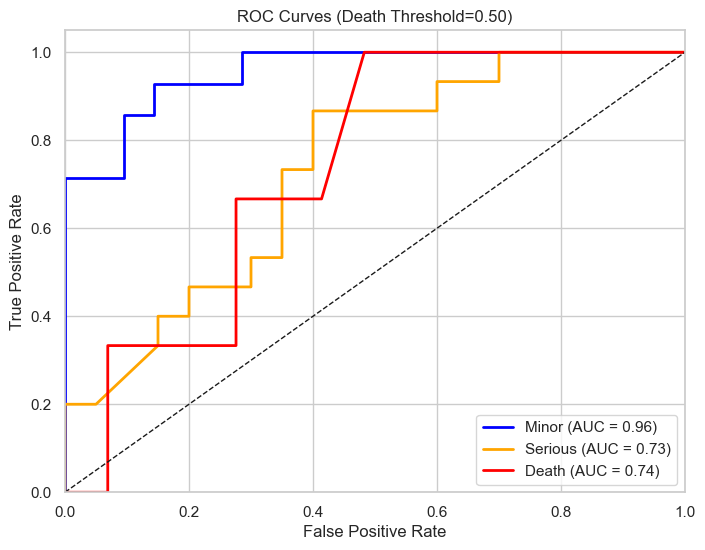

In [42]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0,1,2])  # Minor=0, Serious=1, Death=2

# Plot ROC curve
plt.figure(figsize=(8,6))
colors = ['blue', 'orange', 'red']
class_names = ['Minor','Serious','Death']

for i, color in zip(range(3), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves (Death Threshold={best_th:.2f})')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [43]:
#saving results into a separate df for comparisons

dfresults_labels = pd.Series(['F1Score','balanced_accuracy','accuracy','mean fit time'], name='Performance_Metrics:')
dfresults_values = pd.Series([f1_weighted, balanced_acc, accuracy, mean__fittime],name = 'XGBoost_Metrics_Values')
df_results = pd.concat([dfresults_labels, dfresults_values], axis =1)
df_results

metrics_file = "results/XGBoost_performance_metrics.csv"
df_results.to_csv(metrics_file, index=False)

#RF Y test values
XGBoost_Ytest_file = "results/XGBoost_Ytest.csv"
y_test.to_csv(XGBoost_Ytest_file, index=False)

#RF Y predicted values
XGBoost_Ypred_file = "results/XGBoost_Ypred.csv"
df_y_pred = pd.DataFrame(y_test_pred)
df_y_pred.to_csv(XGBoost_Ypred_file, index=False)

#Y prediction probabilities for the curve analysis
XGBoost_Yscore_file = "results/XGBoost_Y_pred_score.csv"
df_y_pred_score = pd.DataFrame(y_probs)
df_y_pred_score.to_csv(XGBoost_Yscore_file, index=False)

#permutation importance
XGBoost_perm_file = "results/XGBoost_Perm_Importance.csv"
perm_imp_df.to_csv(XGBoost_perm_file, index=False)